In [102]:
import pandas as pd
import numpy as np

#opening data
import os
import json
import pathlib
import warnings
from joblib import load

# modelling
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pickle
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

#used for plots
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
from mplsoccer import Pitch
from mplsoccer import PyPizza, FontManager
from scipy.stats import binned_statistic_2d
from scipy import stats

pd.options.mode.chained_assignment = None
warnings.filterwarnings('ignore')

## Load the data

In [103]:
#load data - store it in train dataframe
# path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', 'events_England.json')
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', 'events_Italy.json')
with open(path) as f: 
    data = json.load(f) 
train = pd.DataFrame(data)
    
#potential data collection error handling
train = train.loc[train.apply (lambda x: len(x.positions) == 2, axis = 1)]
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647231 entries, 0 to 647371
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   eventId       647231 non-null  int64  
 1   subEventName  647231 non-null  object 
 2   tags          647231 non-null  object 
 3   playerId      647231 non-null  int64  
 4   positions     647231 non-null  object 
 5   matchId       647231 non-null  int64  
 6   eventName     647231 non-null  object 
 7   teamId        647231 non-null  int64  
 8   matchPeriod   647231 non-null  object 
 9   eventSec      647231 non-null  float64
 10  subEventId    647231 non-null  object 
 11  id            647231 non-null  int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 64.2+ MB


In [104]:
train['eventName'].unique()

array(['Pass', 'Others on the ball', 'Duel', 'Foul', 'Free Kick',
       'Interruption', 'Shot', 'Save attempt', 'Offside',
       'Goalkeeper leaving line'], dtype=object)

In [105]:
train['subEventName'].unique()

array(['Simple pass', 'Touch', 'Ground attacking duel',
       'Ground defending duel', 'Ground loose ball duel', 'Foul',
       'Free Kick', 'Cross', 'Ball out of the field', 'Goal kick',
       'Air duel', 'Smart pass', 'Clearance', 'Throw in', 'High pass',
       'Head pass', 'Shot', 'Save attempt', 'Hand pass', '',
       'Acceleration', 'Launch', 'Corner', 'Free kick shot', 'Reflexes',
       'Free kick cross', 'Goalkeeper leaving line', 'Hand foul',
       'Penalty', 'Protest', 'Whistle', 'Late card foul',
       'Time lost foul', 'Out of game foul', 'Simulation', 'Violent Foul'],
      dtype=object)

In [106]:
train['tags']

0                                   [{'id': 1801}]
1                                   [{'id': 1801}]
2                                               []
3         [{'id': 504}, {'id': 703}, {'id': 1801}]
4         [{'id': 503}, {'id': 703}, {'id': 1801}]
                            ...                   
647367                 [{'id': 801}, {'id': 1801}]
647368                 [{'id': 702}, {'id': 1801}]
647369                 [{'id': 702}, {'id': 1801}]
647370                 [{'id': 703}, {'id': 1801}]
647371                 [{'id': 701}, {'id': 1802}]
Name: tags, Length: 647231, dtype: object

## Metric 1: Middle 3rd Def Duels Won

In [107]:
def wonDefMidDuels(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    duels_won: dataframe
        dataframe with number of won Ground loose ball duel and Ground defending duel for a player

    """
    #find ground duels won
    ground_def_duels = df.loc[df["subEventName"].isin(["Ground defending duel", "Ground loose ball duel"])]
    won_def_duels = ground_def_duels.loc[ground_def_duels.apply (lambda x:{'id':703} in x.tags, axis = 1)]
    
    #filter for middle 3rd duels
    won_def_duels["x"] = won_def_duels.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    won_def_duels["y"] = won_def_duels.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    won_def_mid_duels = won_def_duels.loc[(won_def_duels["x"] < 2*105/3) & (won_def_duels["x"] > 105/3)]
    
    #group and sum duels
    result = won_def_mid_duels.groupby(["playerId"]).eventId.count().reset_index()
    result.rename(columns = {'eventId':'def_mid_duels_won'}, inplace=True)

    #outer join
    return result

def_mid_duels = wonDefMidDuels(train)

#investigate structure
def_mid_duels.sort_values(by="def_mid_duels_won", ascending=False)

,playerId,def_mid_duels_won
0,0,1078
30,7965,84
247,40726,75
402,333571,70
399,302799,63
...,...,...
254,49979,1
244,37959,1
436,377757,1
431,364640,1


## Metric 2: Middle 3rd Fouls committed

In [108]:
def midFouls(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    mid_fouls: dataframe
        dataframe with number of middle third fouls.

    """
    #get fouls
    fouls = df.loc[df["eventName"] == "Foul"]
    
    #filter for middle 3rd duels
    fouls["x"] = fouls.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
    fouls["y"] = fouls.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
    fouls = fouls.loc[(fouls["x"] < 2*105/3) & (fouls["x"] > 105/3)]

    #sum by player
    mid_fouls = fouls.groupby(["playerId"]).eventId.count().reset_index()
    mid_fouls.rename(columns = {'eventId':'mid_fouls'}, inplace=True)

    return mid_fouls

mid_fouls = midFouls(train)

#investigate structure
mid_fouls.head()

,playerId,mid_fouls
0,0,23
1,114,25
2,122,13
3,130,11
4,174,1


In [109]:
mid_fouls.sort_values(by='mid_fouls', ascending=False)

,playerId,mid_fouls
42,14903,41
381,286223,40
7,625,36
216,22933,34
397,328336,33
...,...,...
423,368340,1
245,40806,1
373,272280,1
24,3795,1


## Metric 3: Middle 3rd Successful Interceptions

In [110]:
def successfulDefMidInterceptions(df):
    """
    Parameters
    ----------
    df : dataframe
        dataframe with Wyscout event data.

    Returns
    -------
    successful_interceptions: dataframe
        dataframe with number of successfull middle 3rd interceptions for a player

    """
    next_event = df.shift(-1, fill_value=0)
    df["nextEvent"] = next_event["subEventName"]
    df["nextPlayerId"] = next_event["playerId"]
    df["nextTeamId"] = next_event["teamId"]
    df["kickedOut"] = df.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

    #get passes
    pass_df = df.loc[train['eventName'] == "Pass"]
    #filtering out of the field
    delete_passes = pass_df.loc[pass_df["kickedOut"] == 1]
    pass_df = pass_df.drop(delete_passes.index)
    
    # calculate end coordinates   
    pass_df["end_x"] = pass_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
    pass_df["end_y"] = pass_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)
    
    # filter intercepted passes only    
    interceptions = pass_df.loc[pass_df.apply(lambda x:{'id':1401} in x.tags, axis = 1) & (pass_df["end_x"] < 2*105/3) & (pass_df["end_x"] > 105/3)]
    interecepted = interceptions.loc[interceptions["teamId"] != interceptions["nextTeamId"]]
    
    #group and sum duels
    result = interecepted.groupby(["nextPlayerId"]).eventId.count().reset_index()
    result.rename(columns = {'nextPlayerId': 'playerId', 'eventId':'def_mid_successful_interceptions'}, inplace=True)

    return result

def_mid_interceptions = successfulDefMidInterceptions(train)

#investigate structure
def_mid_interceptions.sort_values(by="def_mid_successful_interceptions", ascending=False)

,playerId,def_mid_successful_interceptions
180,22162,24
347,333571,24
149,21315,24
28,7965,21
161,21564,19
...,...,...
277,135927,1
322,267185,1
81,20609,1
82,20626,1


## Metric 4: Middle 3rd Interceptions xT avoided

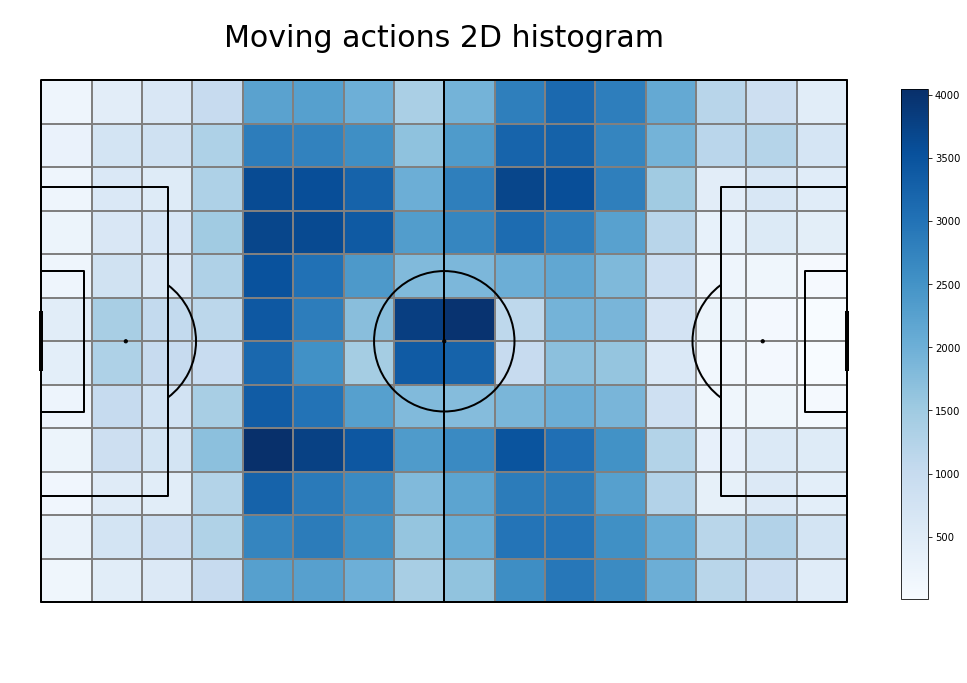

In [111]:
next_event = train.shift(-1, fill_value=0)
train["nextEvent"] = next_event["subEventName"]
train["nextPlayerId"] = next_event["playerId"]
train["nextTeamId"] = next_event["teamId"]

train["kickedOut"] = train.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
move_df = train.loc[train['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]

#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

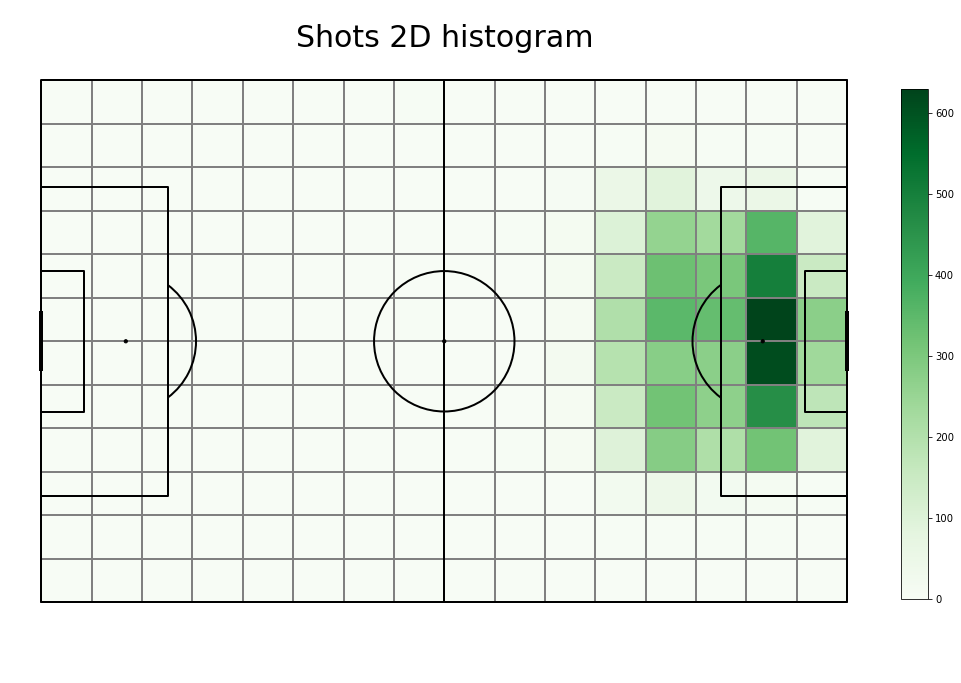

In [112]:
#get shot df
shot_df = train.loc[train['subEventName'] == "Shot"]
shot_df["x"] = shot_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
shot_df["y"] = shot_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
shot = pitch.bin_statistic(shot_df.x, shot_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shots 2D histogram', fontsize = 30)
plt.show()

shot_count = shot["statistic"]

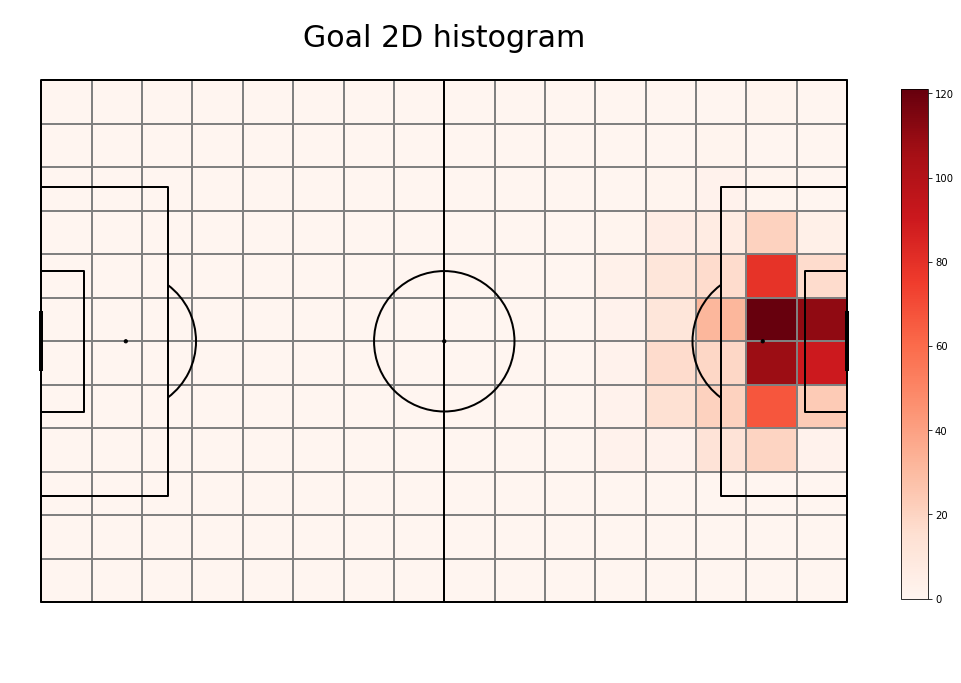

In [113]:
#get goal df
goal_df  = shot_df.loc[shot_df.apply(lambda x: {'id':101} in x.tags, axis = 1)]
goal = pitch.bin_statistic(goal_df.x, goal_df.y, statistic='count', bins=(16, 12), normalize=False)
goal_count = goal["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal 2D histogram', fontsize = 30)
plt.show()

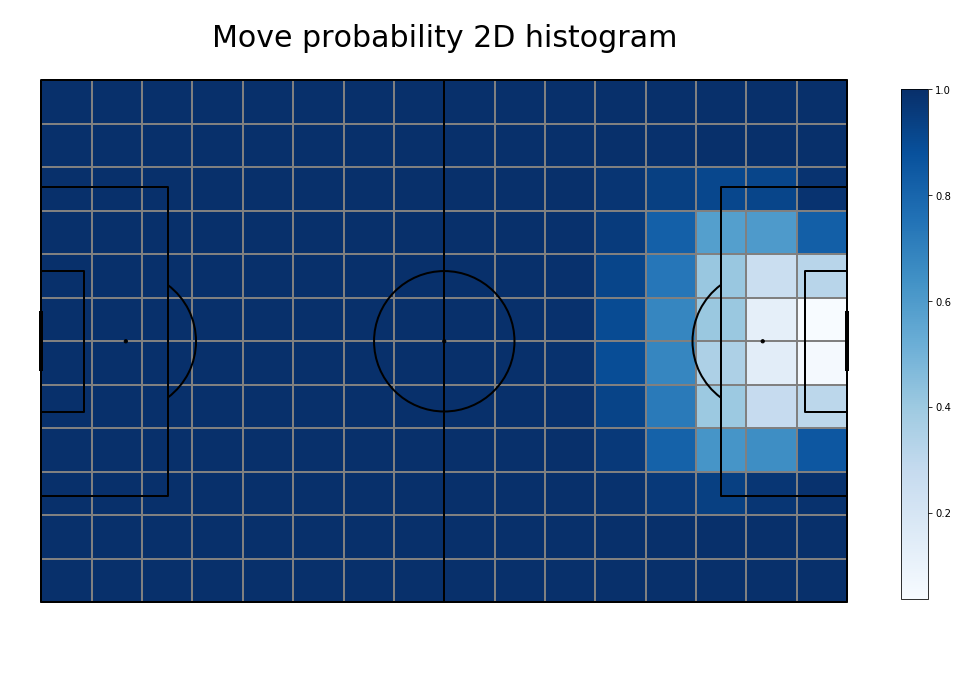

In [114]:
move_probability = move_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

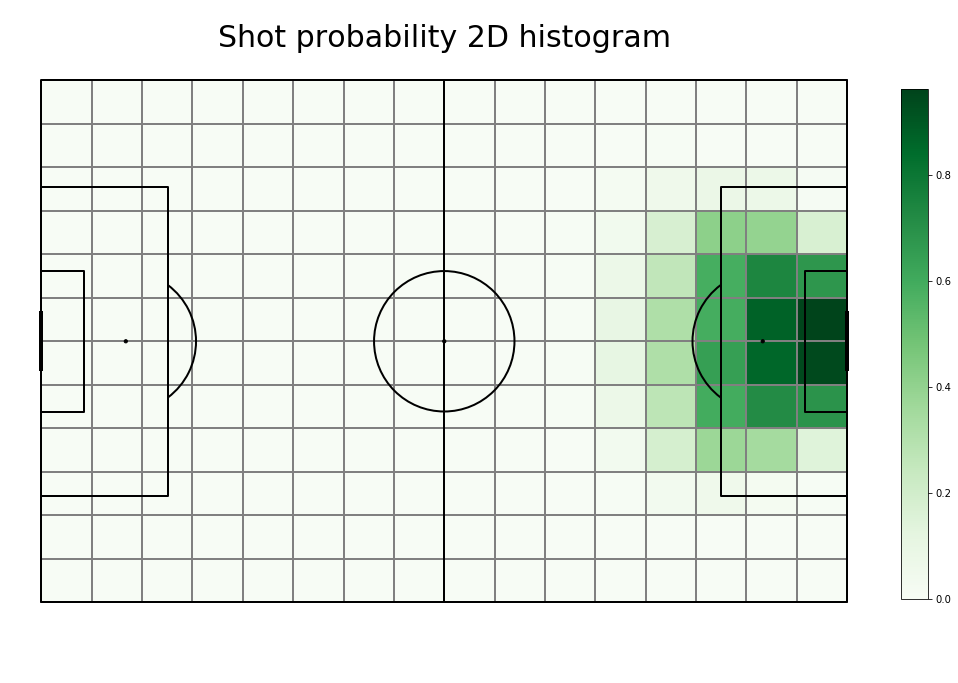

In [115]:
shot_probability = shot_count/(move_count+shot_count)
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
shot["statistic"] = shot_probability
pcm  = pitch.heatmap(shot, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Shot probability 2D histogram', fontsize = 30)
plt.show()

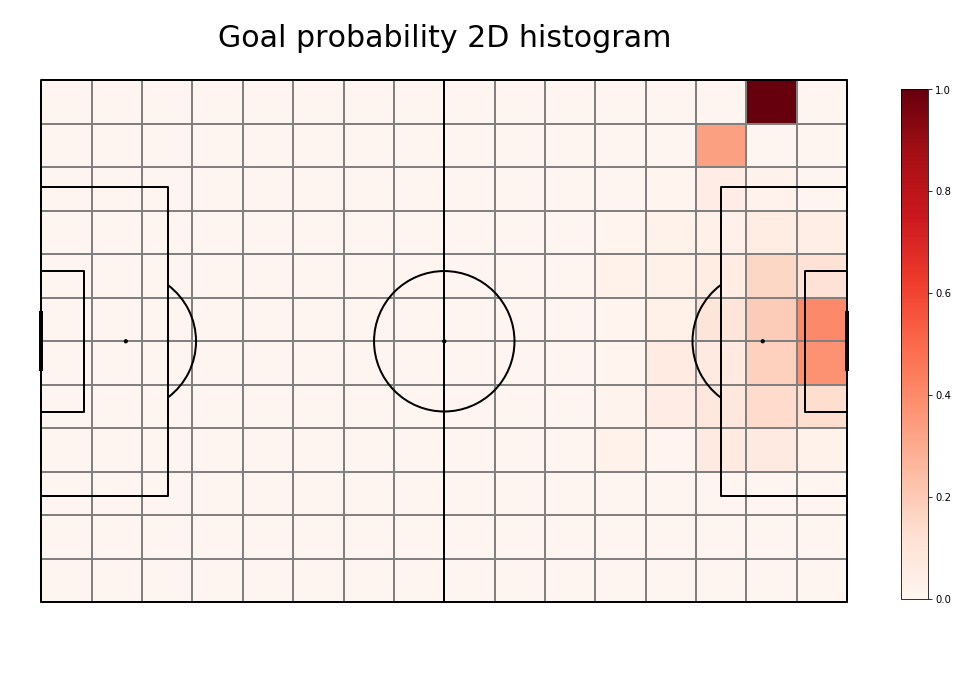

In [116]:
goal_probability = goal_count/shot_count
goal_probability[np.isnan(goal_probability)] = 0
#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
goal["statistic"] = goal_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Goal probability 2D histogram', fontsize = 30)
plt.show()

In [117]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_count_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_count_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_count_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

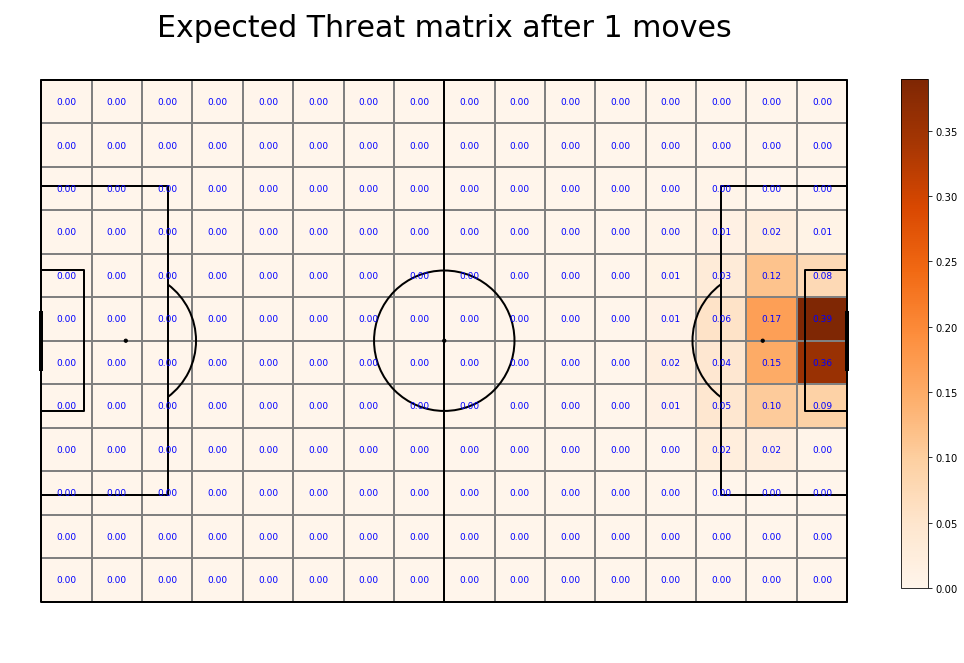

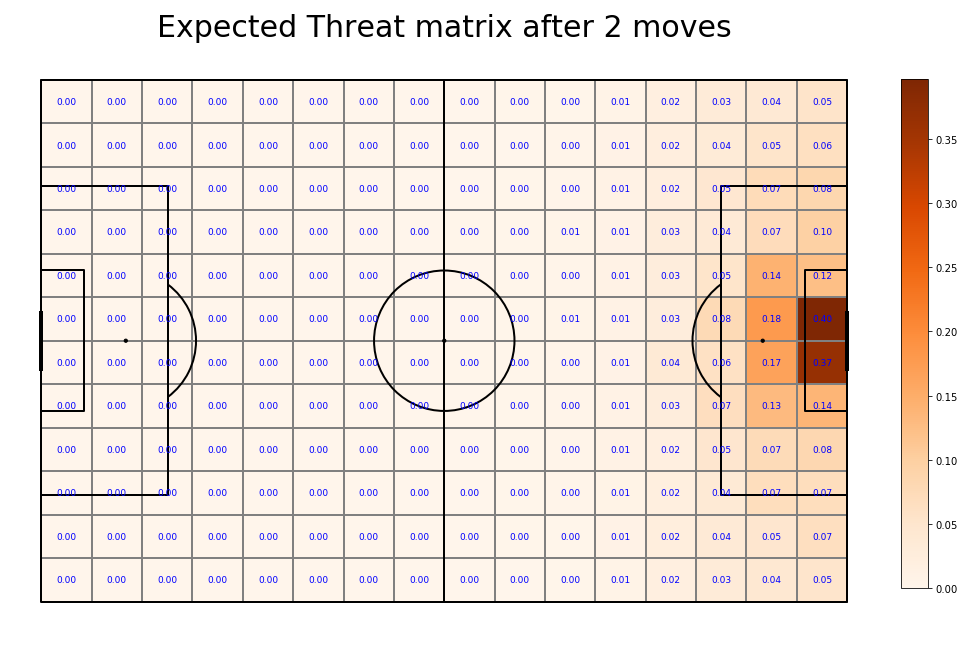

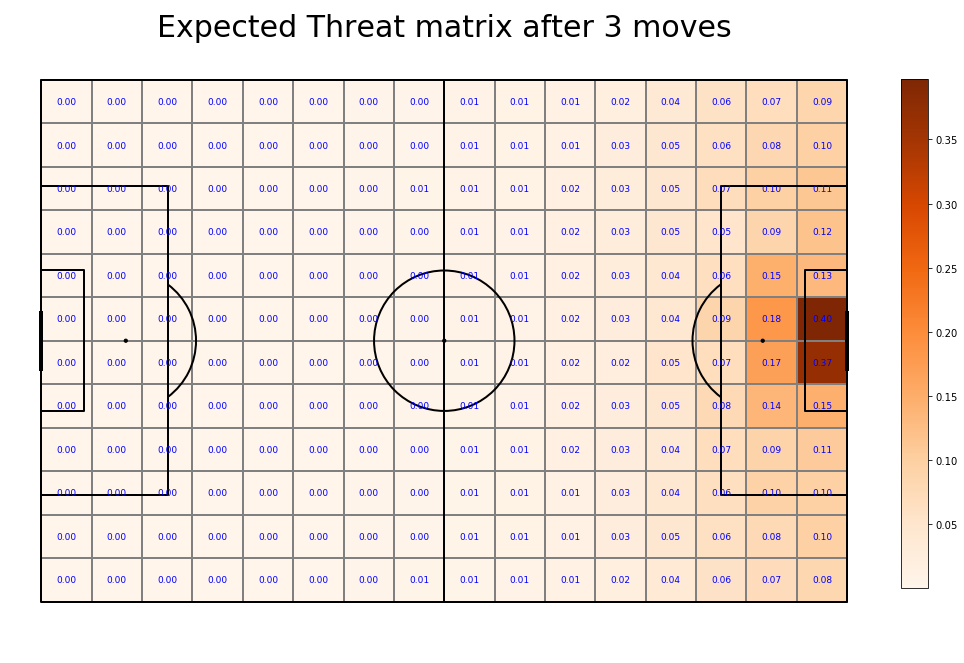

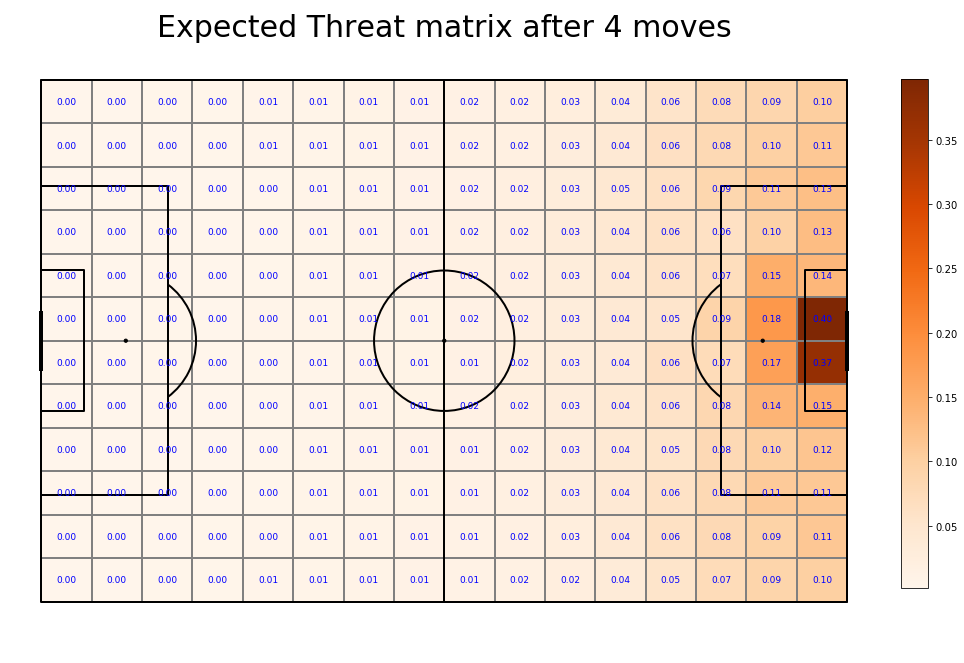

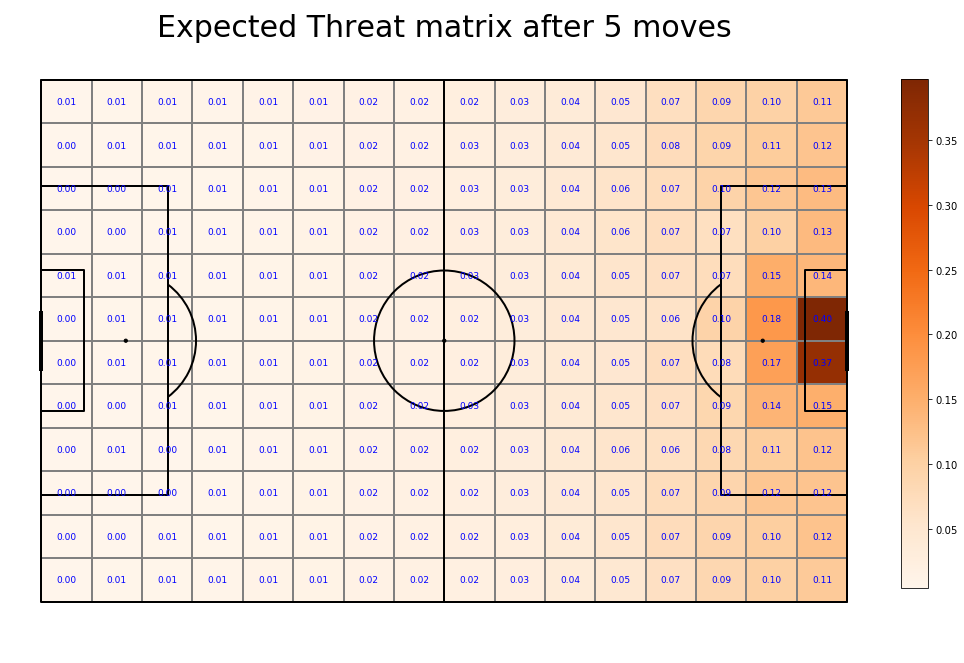

In [118]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))

for i in range(5):
    shoot_expected_payoff = goal_probability*shot_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = shoot_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.01, title_space=0, endnote_space=0)
    
    goal["statistic"] = xT
    pcm  = pitch.heatmap(goal, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(goal, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

In [119]:
# intercepted middle 3rd passes
interceptions = move_df.loc[move_df.apply(lambda x:{'id':1401} in x.tags, axis = 1) & (move_df["end_x"] < 2*105/3) & (move_df["end_x"] > 105/3)]

# calculate potential xT
interceptions["xT_saved"] = interceptions.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1], axis = 1)

# only if possession changes
value_saving_actions = interceptions.loc[interceptions["teamId"] != interceptions["nextTeamId"]]

In [120]:
#group by player
xT_saved_by_player = value_saving_actions.groupby(["nextPlayerId"])["xT_saved"].sum().reset_index()
xT_saved_by_player.rename(columns = {"nextPlayerId": "playerId"}, inplace = True)

xT_saved_by_player

,playerId,xT_saved
0,45,0.015325
1,114,0.266160
2,122,0.040836
3,130,0.113774
4,174,0.029050
...,...,...
377,417231,0.078320
378,424241,0.063167
379,447804,0.149340
380,491409,0.018730


## Metric 5: Middle 3rd Def Duels Counterattack xT

In [121]:
train.loc[train["subEventName"].isin(["Ground defending duel", "Ground loose ball duel"])]\
        .loc[train.apply (lambda x:{'id':703} in x.tags, axis = 1)]

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id,nextEvent,nextPlayerId,nextTeamId,kickedOut
12,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",8306,"[{'y': 12, 'x': 61}, {'y': 15, 'x': 61}]",2575959,Duel,3158,1H,17.715422,13,180423967,Ground loose ball duel,246175,3172,0
47,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",8306,"[{'y': 16, 'x': 37}, {'y': 12, 'x': 40}]",2575959,Duel,3158,1H,121.083515,13,180423996,Foul,41034,3172,0
50,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",23149,"[{'y': 88, 'x': 87}, {'y': 86, 'x': 86}]",2575959,Duel,3158,1H,153.859538,13,180424004,Ground loose ball duel,295176,3172,0
63,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",21077,"[{'y': 34, 'x': 68}, {'y': 32, 'x': 70}]",2575959,Duel,3172,1H,188.486240,13,180424024,Ground loose ball duel,114,3158,0
78,1,Ground defending duel,"[{'id': 703}, {'id': 1801}]",8327,"[{'y': 30, 'x': 56}, {'y': 13, 'x': 56}]",2575959,Duel,3158,1H,217.327247,12,180424055,Ground attacking duel,280419,3172,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647243,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",14903,"[{'y': 43, 'x': 23}, {'y': 46, 'x': 30}]",2576338,Duel,3185,2H,2444.876451,13,253567040,Ground loose ball duel,70974,3193,0
647269,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",25558,"[{'y': 55, 'x': 10}, {'y': 53, 'x': 7}]",2576338,Duel,3185,2H,2538.714394,13,253567057,Ground loose ball duel,115933,3193,0
647274,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",413041,"[{'y': 22, 'x': 41}, {'y': 30, 'x': 43}]",2576338,Duel,3193,2H,2555.784789,13,253567039,Ground loose ball duel,354552,3185,0
647311,1,Ground loose ball duel,"[{'id': 703}, {'id': 1801}]",354552,"[{'y': 86, 'x': 71}, {'y': 92, 'x': 66}]",2576338,Duel,3185,2H,2683.548366,13,253567109,Ground loose ball duel,20749,3193,0


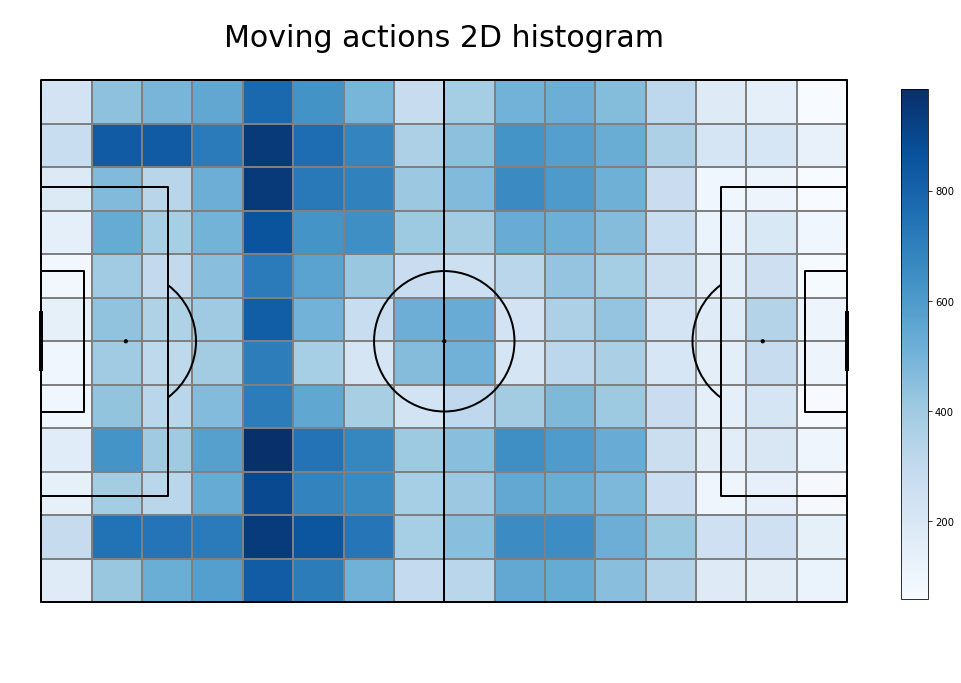

In [122]:
next_event = train.shift(-1, fill_value=0)
train["nextEvent"] = next_event["subEventName"]
train["nextPlayerId"] = next_event["playerId"]
train["nextTeamId"] = next_event["teamId"]

train["kickedOut"] = train.apply(lambda x: 1 if x.nextEvent == "Ball out of the field" else 0, axis = 1)

#get move_df
# move_df = df.loc[df['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
move_df = train.loc[train['subEventName'].isin(['Ground defending duel', 'Ground loose ball duel'])]

#filtering out of the field
delete_passes = move_df.loc[move_df["kickedOut"] == 1]
move_df = move_df.drop(delete_passes.index)

#extract coordinates
move_df["x"] = move_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
move_df["y"] = move_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)
move_df["end_x"] = move_df.positions.apply(lambda cell: (cell[1]['x']) * 105/100)
move_df["end_y"] = move_df.positions.apply(lambda cell: (100 - cell[1]['y']) * 68/100)

#create 2D histogram of these
pitch = Pitch(line_color='black',pitch_type='custom', pitch_length=105, pitch_width=68, line_zorder = 2)
move = pitch.bin_statistic(move_df.x, move_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Moving actions 2D histogram', fontsize = 30)
plt.show()
#get the array
move_count = move["statistic"]

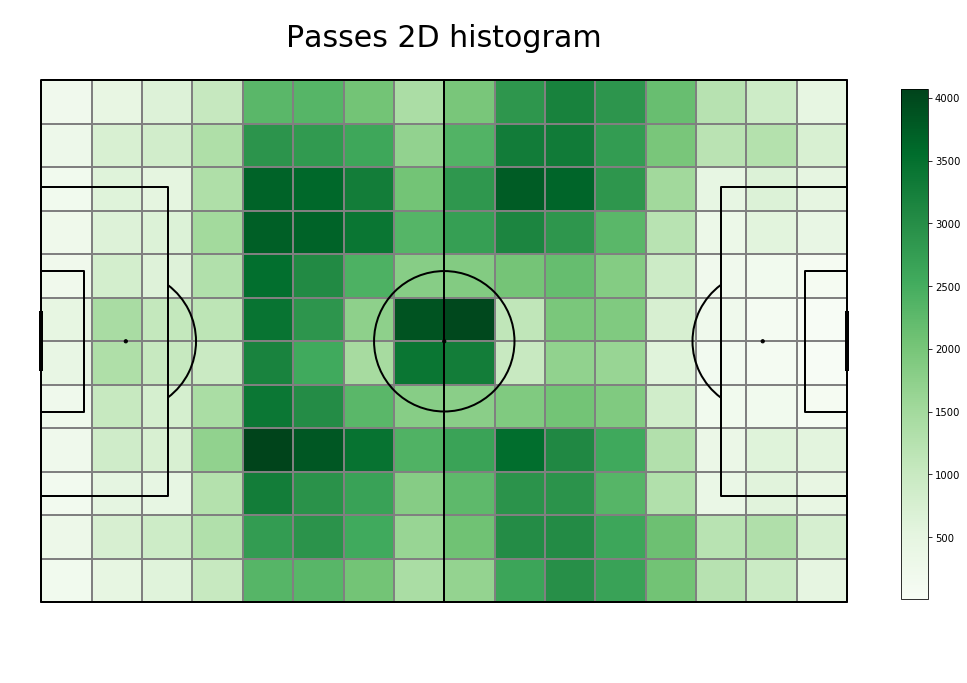

In [123]:
#get pass df
# shot_df = df.loc[df['subEventName'] == "Shot"]
pass_df = train.loc[train['subEventName'].isin(['Simple pass', 'High pass', 'Head pass', 'Smart pass', 'Cross'])]
pass_df["x"] = pass_df.positions.apply(lambda cell: (cell[0]['x']) * 105/100)
pass_df["y"] = pass_df.positions.apply(lambda cell: (100 - cell[0]['y']) * 68/100)

#create 2D histogram of these
pass_ = pitch.bin_statistic(pass_df.x, pass_df.y, statistic='count', bins=(16, 12), normalize=False)

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(pass_, cmap='Greens', edgecolor='grey', ax=ax['pitch'])
#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Passes 2D histogram', fontsize = 30)
plt.show()

pass_count = pass_["statistic"]

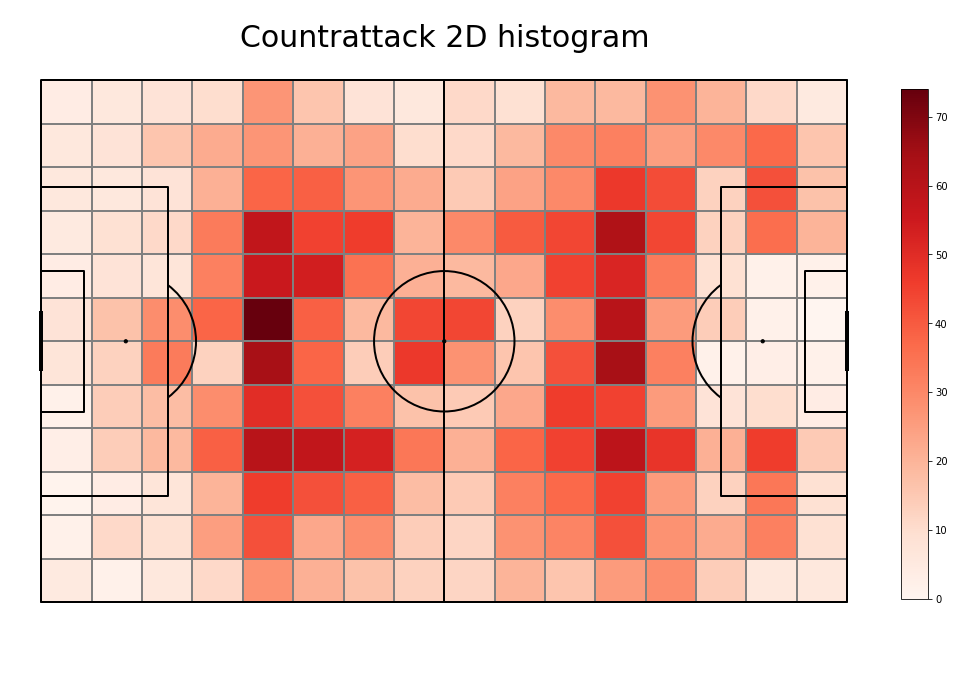

In [124]:
#get counterattack df
counter_attack_df  = pass_df.loc[pass_df.apply(lambda x: {'id':1901} in x.tags, axis = 1)]
counter_attack = pitch.bin_statistic(counter_attack_df.x, counter_attack_df.y, statistic='count', bins=(16, 12), normalize=False)
counter_attack_count = counter_attack["statistic"]

fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pcm  = pitch.heatmap(counter_attack, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Countrattack 2D histogram', fontsize = 30)
plt.show()

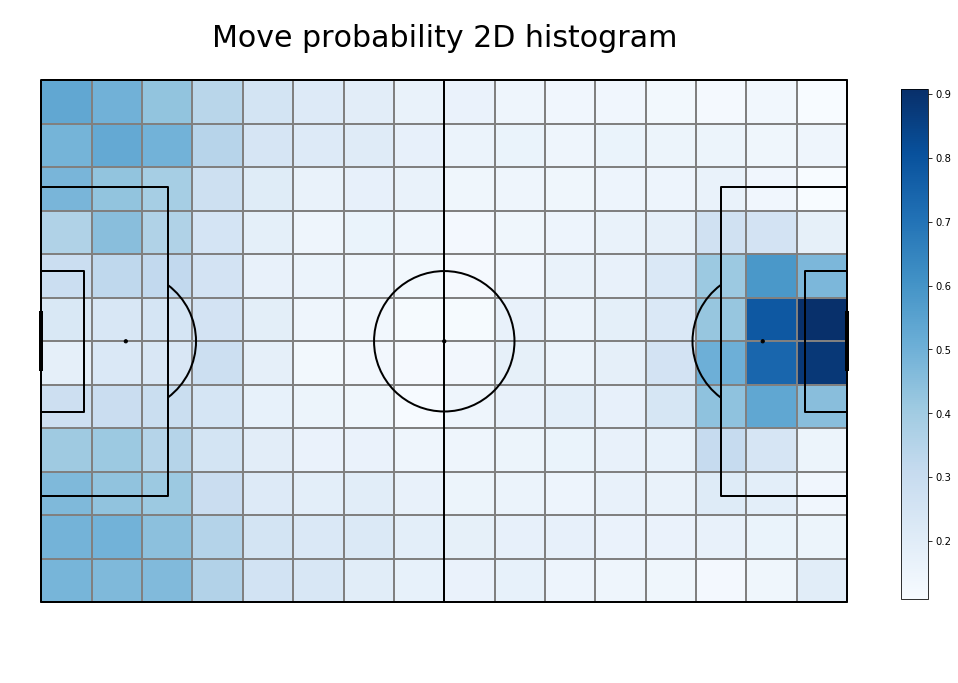

In [125]:
move_probability = move_count/(move_count+pass_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
move["statistic"] = move_probability
pcm  = pitch.heatmap(move, cmap='Blues', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Move probability 2D histogram', fontsize = 30)
plt.show()

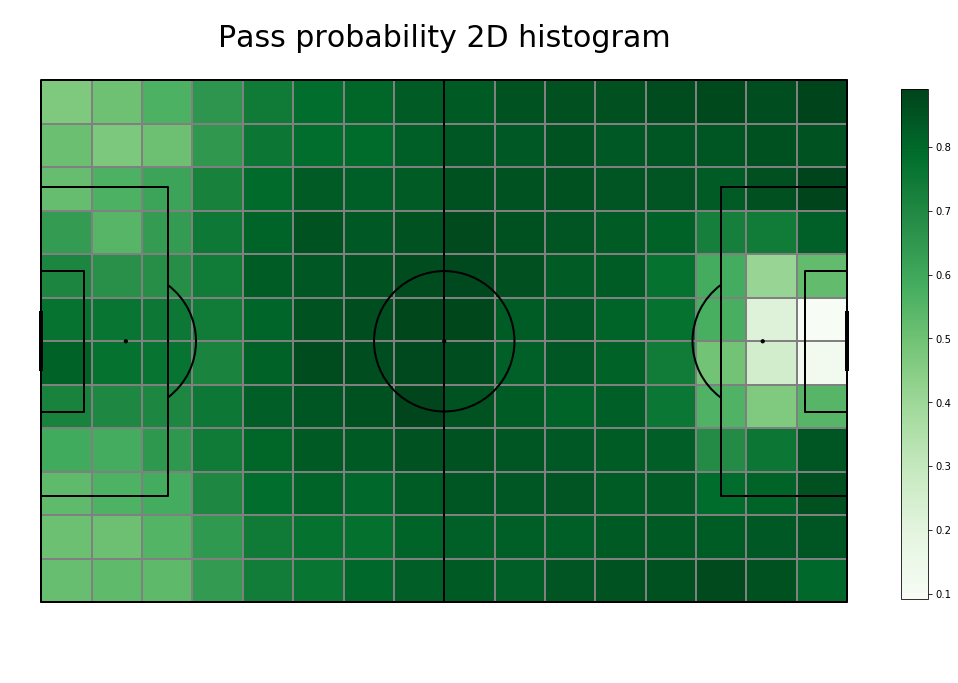

In [126]:
pass_probability = pass_count/(move_count+pass_count)

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pass_["statistic"] = pass_probability
pcm  = pitch.heatmap(pass_, cmap='Greens', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Pass probability 2D histogram', fontsize = 30)
plt.show()

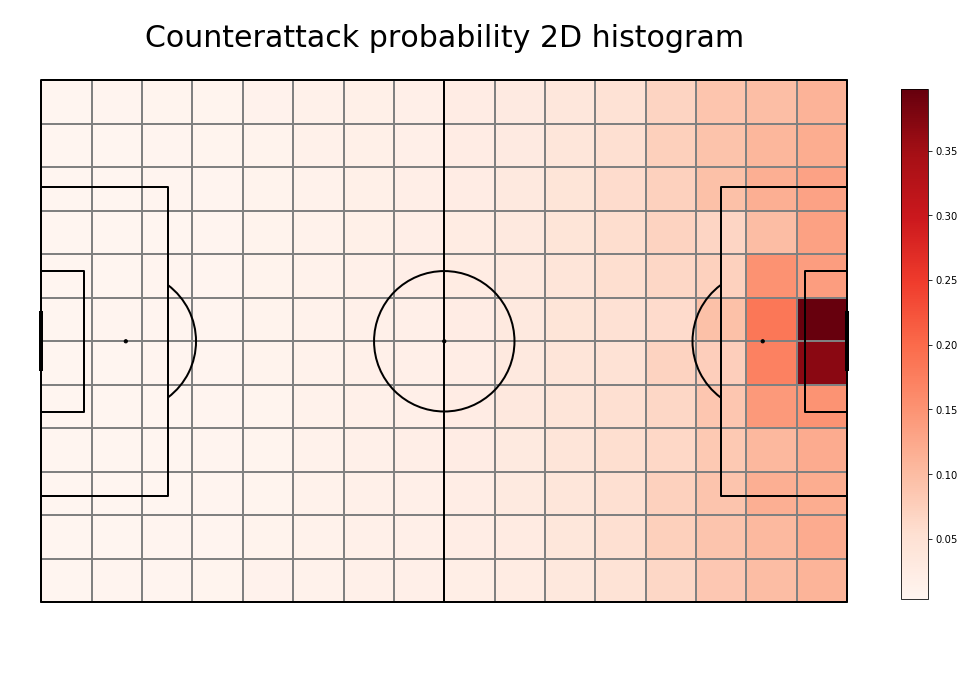

In [127]:
counter_attack_probability = counter_attack_count/pass_count
counter_attack_probability[np.isnan(counter_attack_probability)] = 0

#plotting it
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
counter_attack["statistic"] = counter_attack_probability
pcm  = pitch.heatmap(goal, cmap='Reds', edgecolor='grey', ax=ax['pitch'])

#legend to our plot
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle('Counterattack probability 2D histogram', fontsize = 30)
plt.show()

In [128]:
#move start index - using the same function as mplsoccer, it should work
move_df["start_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.x), np.ravel(row.y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)
#move end index
move_df["end_sector"] = move_df.apply(lambda row: tuple([i[0] for i in binned_statistic_2d(np.ravel(row.end_x), np.ravel(row.end_y),
                                                               values = "None", statistic="count",
                                                               bins=(16, 12), range=[[0, 105], [0, 68]],
                                                               expand_binnumbers=True)[3]]), axis = 1)

#df with summed events from each index
df_count_starts = move_df.groupby(["start_sector"])["eventId"].count().reset_index()
df_count_starts.rename(columns = {'eventId':'count_starts'}, inplace=True)

transition_matrices = []
for i, row in df_count_starts.iterrows():
    start_sector = row['start_sector']
    count_starts = row['count_starts']
    
    #get all events that started in this sector
    this_sector = move_df.loc[move_df["start_sector"] == start_sector]
    df_count_ends = this_sector.groupby(["end_sector"])["eventId"].count().reset_index()
    df_count_ends.rename(columns = {'eventId':'count_ends'}, inplace=True)
    
    T_matrix = np.zeros((12, 16))
    for j, row2 in df_count_ends.iterrows():
        end_sector = row2["end_sector"]
        value = row2["count_ends"]
        T_matrix[end_sector[1] - 1][end_sector[0] - 1] = value
    T_matrix = T_matrix / count_starts
    transition_matrices.append(T_matrix)

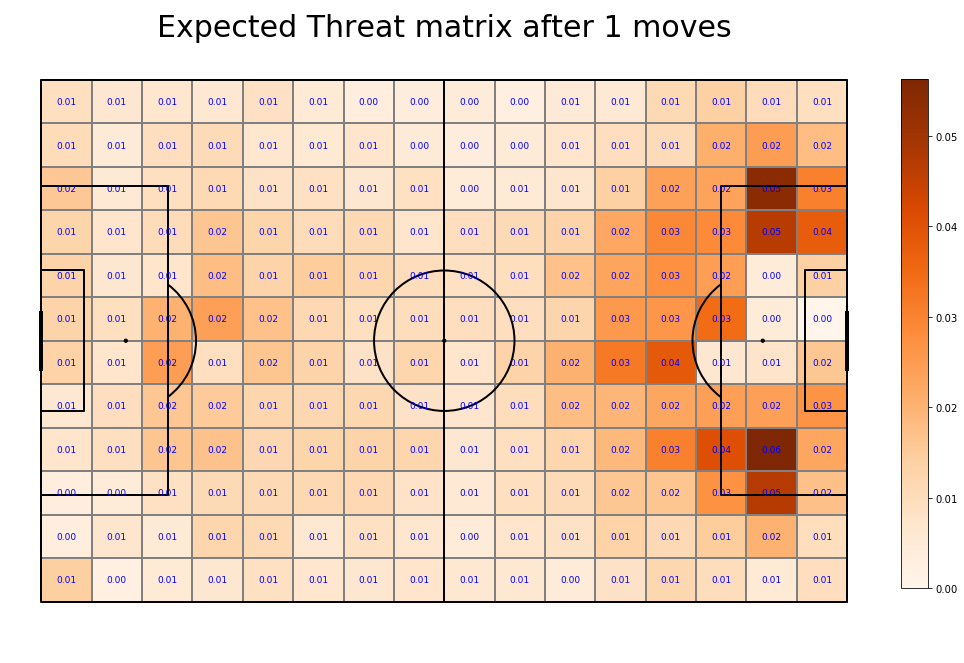

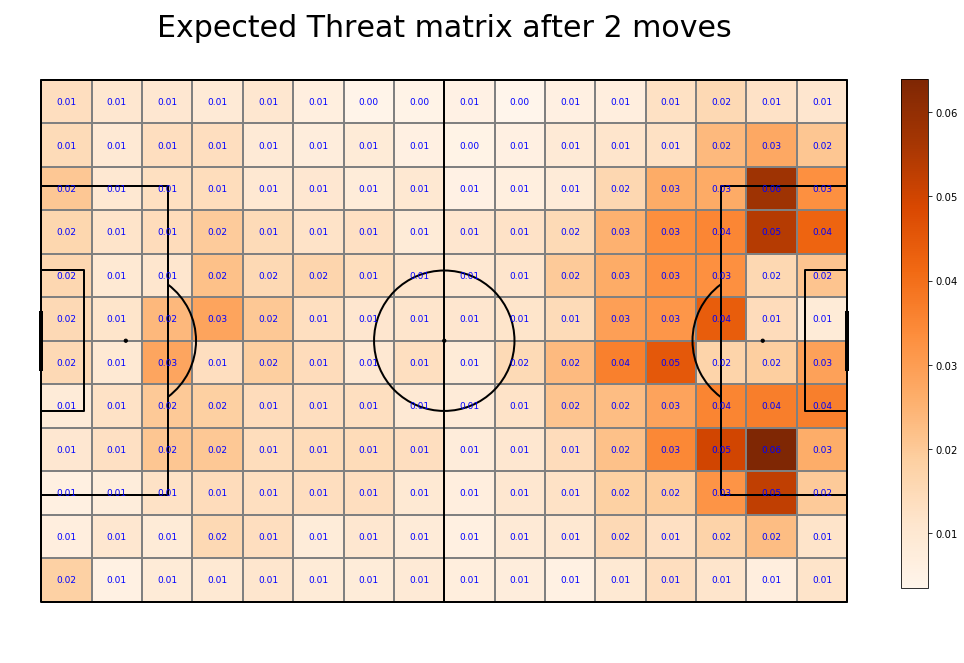

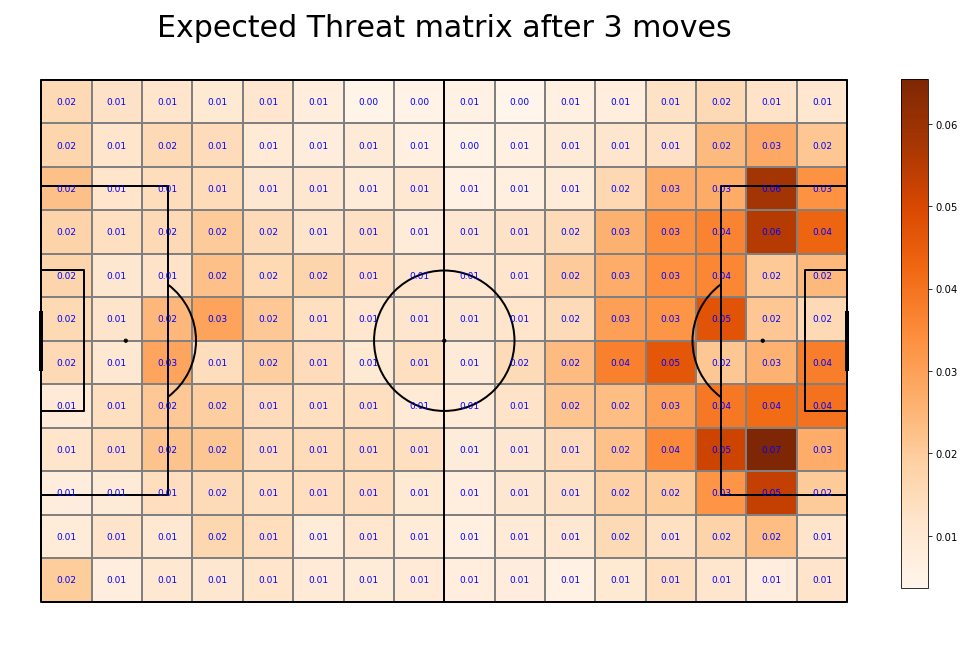

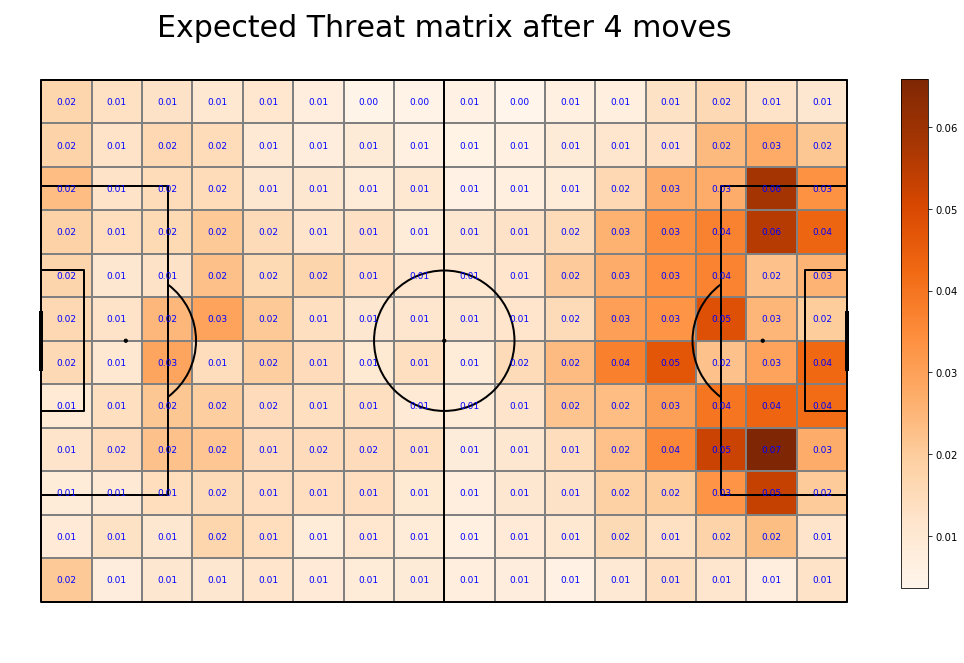

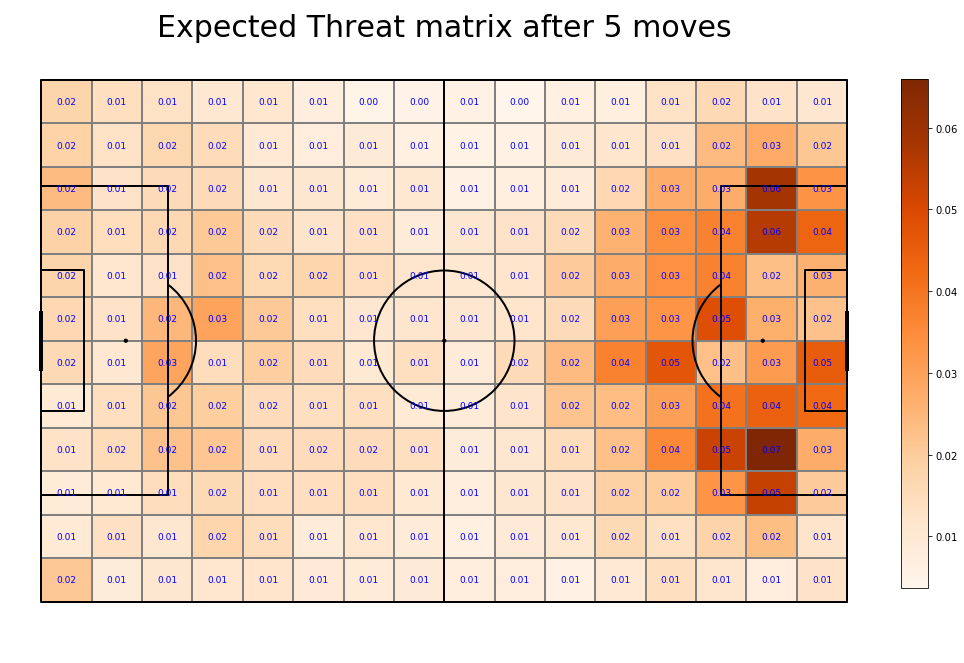

In [129]:
transition_matrices_array = np.array(transition_matrices)
xT = np.zeros((12, 16))

for i in range(5):
    pass_expected_payoff = counter_attack_probability*pass_probability
    move_expected_payoff = move_probability*(np.sum(np.sum(transition_matrices_array*xT, axis = 2), axis = 1).reshape(16,12).T)
    xT = pass_expected_payoff + move_expected_payoff

    #let's plot it!
    fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.01, title_space=0, endnote_space=0)
    
    counter_attack["statistic"] = xT
    pcm  = pitch.heatmap(counter_attack, cmap='Oranges', edgecolor='grey', ax=ax['pitch'])
    labels = pitch.label_heatmap(counter_attack, color='blue', fontsize=9,
                             ax=ax['pitch'], ha='center', va='center', str_format="{0:,.2f}", zorder = 3)
    #legend to our plot
    ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
    cbar = plt.colorbar(pcm, cax=ax_cbar)
    txt = 'Expected Threat matrix after ' +  str(i+1) + ' moves'
    fig.suptitle(txt, fontsize = 30)
    plt.show()

In [130]:
#only successful middle 3rd duels
successful_duels = move_df.loc[move_df.apply(lambda x:{'id':1801} in x.tags, axis = 1) & (move_df["end_x"] < 2*105/3) & (move_df["end_x"] > 105/3)]

#calculatexT
successful_duels["xT_added"] = successful_duels.apply(lambda row: xT[row.end_sector[1] - 1][row.end_sector[0] - 1] , axis = 1)

#only progressive
value_adding_actions = successful_duels

In [131]:
#group by player
xT_added_by_player = value_adding_actions.groupby(["playerId"])["xT_added"].sum().reset_index()

xT_added_by_player

,playerId,xT_added
0,0,19.056184
1,45,0.017023
2,114,0.650640
3,122,0.323994
4,130,0.565567
...,...,...
465,454457,0.183022
466,481329,0.035236
467,485464,0.012374
468,491409,0.038942


## Metric 6: Def Duels Possession Chain xT

In [132]:
df = pd.DataFrame()
# file_name = 'possession_chains_England.json'
file_name = 'possession_chains_Italy.json'
path = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'events', file_name)
with open(path) as f:
    data = json.load(f)
df = pd.DataFrame(data)
# df = df.reset_index()

In [133]:
#model variables
var = ["x0", "x1", "c0", "c1"]

#combinations
inputs = []
#1 variable combinations
inputs.extend(combinations_with_replacement(var, 1))
#2 variable combinations
inputs.extend(combinations_with_replacement(var, 2))
#3 variable combinations
inputs.extend(combinations_with_replacement(var, 3))

#make new columns
for i in inputs:
    #columns length 1 already exist
    if len(i) > 1:
        #column name
        column = ''
        x = 1
        for c in i:
            #add column name to be x0x1c0 for example
            column += c
            #multiply values in column
            x = x*df[c]
        #create a new column in df
        df[column] = x
        #add column to model variables
        var.append(column)
#investigate 3 columns
df.head(3)

,index,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,...,x1x1x1,x1x1c0,x1x1c1,x1c0c0,x1c0c1,x1c1c1,c0c0c0,c0c0c1,c0c1c1,c1c1c1
0,0,8,Simple pass,[{'id': 1801}],8327,"[{'y': 52, 'x': 49}, {'y': 44, 'x': 43}]",2575959,Pass,3158,1H,...,92039.290875,2772.3906,8317.1718,83.50944,250.52832,751.58496,2.515456,7.546368,22.639104,67.917312
1,1,8,Simple pass,[{'id': 1801}],20438,"[{'y': 44, 'x': 43}, {'y': 17, 'x': 36}]",2575959,Pass,3158,1H,...,54010.152000,5829.6672,32063.1696,629.23392,3460.78656,19034.32608,67.917312,373.545216,2054.498688,11299.742784
2,2,7,Touch,[],8306,"[{'y': 17, 'x': 36}, {'y': 56, 'x': 78}]",2575959,Others on the ball,3158,1H,...,549353.259000,150518.7684,27367.0488,41241.03984,7498.37088,1363.34016,11299.742784,2054.498688,373.545216,67.917312


In [134]:
#predict if possession chains containing duels ended with a shot
duels = df.loc[df["subEventName"].isin(["Ground defending duel"])]
X1 = duels[var].values
y1 = duels["shot_end"].values

#path to saved model
path_model = os.path.join(str(pathlib.Path().resolve().parents[0]), 'data', 'Wyscout', 'models', 'xgb_def_duels_model_Germany.pkl')
xgb_model = load(path_model)

#predict probability of shot ended
y_pred_shot = xgb_model.predict(X1)
duels["shot_prob"] = y_pred_shot

#OLS
shot_ended = duels.loc[duels["shot_end"] == 1]
X2 = shot_ended[var].values
y2 = shot_ended["xG"].values
lr = LinearRegression()
lr.fit(X2, y2)

#predict probability of goal being scored
y_pred_goal = lr.predict(X1)
duels["xG_pred"] = y_pred_goal

#calculate xGchain
duels["xT_action_based"] = duels["shot_prob"] * duels["xG_pred"]
duels[["shot_prob", "xG_pred", "xT_action_based"]].head(5)

,shot_prob,xG_pred,xT_action_based
78,0.010955,0.157487,0.001725
193,0.014388,0.158082,0.002275
194,0.016171,0.094795,0.001533
361,-0.000719,0.131464,-0.000095
498,0.405946,0.167941,0.068175


In [135]:
xT_duels = duels[["playerId", "xT_action_based"]].groupby(["playerId"]).sum().reset_index()

In [136]:
xT_duels

,playerId,xT_action_based
0,0,1.987223
1,45,0.002687
2,114,0.133947
3,122,-0.396562
4,130,0.019260
...,...,...
463,454457,-0.022644
464,481329,0.000490
465,485464,0.001145
466,491409,0.021175


## Normalize the metrics 

In [137]:
# path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'minutes_played_per_game_England.json')
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", "Wyscout", "minutes_played", 'minutes_played_per_game_Italy.json')
minutes_per_game = pd.read_json(path, encoding='unicode-escape')

# with open(path) as f:
#     minutes_per_game = json.load(f)
# minutes_per_game = pd.DataFrame(minutes_per_game)

minutes = minutes_per_game.groupby(["playerId"]).minutesPlayed.sum().reset_index()
minutes.head(3)

,playerId,minutesPlayed
0,45,313
1,114,2354
2,122,3099


In [138]:
players = train["playerId"].unique()
summary = pd.DataFrame(players, columns = ["playerId"])

summary = summary.merge(def_mid_duels, how="left", on=["playerId"])\
                .merge(def_mid_interceptions, how="left", on=["playerId"])\
                .merge(mid_fouls, how="left", on=["playerId"])\
                .merge(xT_saved_by_player, how="left", on=["playerId"])\
                .merge(xT_added_by_player, how="left", on=["playerId"])\
                .merge(xT_duels, how="left", on=["playerId"])
summary = minutes.merge(summary, how="left", on=["playerId"])

summary = summary.fillna(0)
summary = summary.loc[summary["minutesPlayed"] > 400]
summary.head(3)

,playerId,minutesPlayed,def_mid_duels_won,def_mid_successful_interceptions,mid_fouls,xT_saved,xT_added,xT_action_based
1,114,2354,41.0,14.0,25.0,0.266160,0.650640,0.133947
2,122,3099,20.0,2.0,13.0,0.040836,0.323994,-0.396562
3,130,3144,34.0,8.0,11.0,0.113774,0.565567,0.019260


In [139]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421 entries, 1 to 532
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   playerId                          421 non-null    int64  
 1   minutesPlayed                     421 non-null    int64  
 2   def_mid_duels_won                 421 non-null    float64
 3   def_mid_successful_interceptions  421 non-null    float64
 4   mid_fouls                         421 non-null    float64
 5   xT_saved                          421 non-null    float64
 6   xT_added                          421 non-null    float64
 7   xT_action_based                   421 non-null    float64
dtypes: float64(6), int64(2)
memory usage: 29.6 KB


In [140]:
path = os.path.join(str(pathlib.Path().resolve().parents[0]), "data", 'Wyscout', 'players.json')
player_df = pd.read_json(path, encoding='unicode-escape')

# with open(path) as f:
#     players = json.load(f).encode('utf8')
# player_df = pd.DataFrame(players)

In [141]:
player_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   passportArea           3603 non-null   object
 1   weight                 3603 non-null   int64 
 2   firstName              3603 non-null   object
 3   middleName             3603 non-null   object
 4   lastName               3603 non-null   object
 5   currentTeamId          3512 non-null   object
 6   birthDate              3603 non-null   object
 7   height                 3603 non-null   int64 
 8   role                   3603 non-null   object
 9   birthArea              3603 non-null   object
 10  wyId                   3603 non-null   int64 
 11  foot                   3603 non-null   object
 12  shortName              3603 non-null   object
 13  currentNationalTeamId  3603 non-null   object
dtypes: int64(3), object(11)
memory usage: 394.2+ KB


In [142]:
player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis=1)].head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
9,"{'name': 'Denmark', 'id': '208', 'alpha3code':...",76,Christian,,Dannemann Eriksen,1624,1992-02-14,180,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Denmark', 'id': '208', 'alpha3code':...",54,right,C. Eriksen,7712
10,"{'name': 'Austria', 'id': '40', 'alpha3code': ...",74,Marcel,,Sabitzer,2975,1994-03-17,177,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Austria', 'id': '40', 'alpha3code': ...",65596,right,M. Sabitzer,null
15,"{'name': 'Iceland', 'id': '352', 'alpha3code':...",77,Johann,,Berg Guðmunds­son,1646,1990-10-27,186,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Iceland', 'id': '352', 'alpha3code':...",93,left,J. Guðmunds­son,7839
20,"{'name': 'Netherlands', 'id': '528', 'alpha3co...",78,Kevin,,Strootman,3158,1990-02-13,186,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'Netherlands', 'id': '528', 'alpha3co...",114,left,K. Strootman,null


In [143]:
# we focus only on the midfielders
midfielders = player_df.loc[player_df.apply(lambda x: x.role["name"] == "Midfielder", axis = 1)]
midfielders.rename(columns = {'wyId':'playerId'}, inplace=True)

to_merge = midfielders[['playerId', 'shortName']]
summary = summary.merge(to_merge, how="inner", on=["playerId"])
summary.head(3)

,playerId,minutesPlayed,def_mid_duels_won,def_mid_successful_interceptions,mid_fouls,xT_saved,xT_added,xT_action_based,shortName
0,114,2354,41.0,14.0,25.0,0.266160,0.650640,0.133947,K. Strootman
1,174,1016,13.0,2.0,1.0,0.029050,0.281419,0.040549,F. Đuričić
2,625,2692,62.0,11.0,36.0,0.213111,0.983171,0.071037,M. de Roon


In [144]:
summary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 0 to 142
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   playerId                          143 non-null    int64  
 1   minutesPlayed                     143 non-null    int64  
 2   def_mid_duels_won                 143 non-null    float64
 3   def_mid_successful_interceptions  143 non-null    float64
 4   mid_fouls                         143 non-null    float64
 5   xT_saved                          143 non-null    float64
 6   xT_added                          143 non-null    float64
 7   xT_action_based                   143 non-null    float64
 8   shortName                         143 non-null    object 
dtypes: float64(6), int64(2), object(1)
memory usage: 11.2+ KB


In [145]:
minutes_per_game.head(3)

,playerId,shortName,matchId,teamId,teamName,player_in_min,player_out_min,minutesPlayed,red_card
0,21384,C. Immobile,2576335,3162,SS Lazio,0,75,75,0
1,37745,J. Lukaku,2576335,3162,SS Lazio,75,94,19,0
2,20550,Ş. Radu,2576335,3162,SS Lazio,0,77,77,0


In [146]:
# minutes_per_game.loc[minutes_per_game['teamName']=='Chelsea FC']['shortName'].unique()
minutes_per_game.loc[minutes_per_game['teamName']=='SSC Napoli']['shortName'].unique()

array(['A. Milik', 'D. Mertens', 'L. Insigne', 'M. Hamšík', 'Allan',
       'M. Rog', 'E. Hysaj', 'Jorginho', 'Pepe Reina', 'P. Zieliński',
       'K. Koulibaly', 'Albiol', 'José Callejón', 'Mário Rui', 'A. Ounas',
       'V. Chiricheș', 'L. Tonelli', 'A. Diawara', 'C. Maggio',
       'N. Maksimović', 'L. Sepe', 'E. Giaccherini', 'F. Ghoulam'],
      dtype=object)

In [147]:
possession_dict = {}

#for every row in the dataframe
for i, row in minutes_per_game.iterrows():
    #take player id, team id and match id, minute in and minute out
    player_id, team_id, match_id = row["playerId"], row["teamId"], row["matchId"]
    
    #create a key in dictionary if player encounterd first time
    if not str(player_id) in possession_dict.keys():
        possession_dict[str(player_id)] = {'team_passes': 0, 'all_passes' : 0}
    min_in = row["player_in_min"]*60
    min_out = row["player_out_min"]*60

    #get the dataframe of events from the game
    match_df = train.loc[train["matchId"] == match_id].copy()
    #add to 2H the highest value of 1H
    match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] = (match_df.loc[match_df["matchPeriod"]=="2H", 'eventSec'] 
                                                                + match_df.loc[match_df["matchPeriod"] == "1H"]["eventSec"].iloc[-1])
    #take all events from this game and this period
    player_in_match_df = match_df.loc[match_df["eventSec"] > min_in].loc[match_df["eventSec"] <= min_out]
    #take all passes and won duels as described
    all_passes = player_in_match_df.loc[player_in_match_df["eventName"].isin(["Pass", "Duel"])]
    
    #adjusting for no passes in this period (Tuanzebe)
    if len(all_passes) > 0:
        #removing lost air duels
        no_contact = all_passes.loc[all_passes["subEventName"]\
                                    .isin(["Air duel", "Ground defending duel","Ground loose ball duel"])]\
                                        .loc[all_passes.apply(lambda x:{'id':701} in x.tags, axis = 1)]
        all_passes = all_passes.drop(no_contact.index)
    
    #take team passes
    team_passes = all_passes.loc[all_passes["teamId"] == team_id]
    #append it {player id: {team passes: sum, all passes : sum}}
    possession_dict[str(player_id)]["team_passes"] += len(team_passes)
    possession_dict[str(player_id)]["all_passes"] += len(all_passes)

In [148]:
possession_dict

{'21384': {'team_passes': 18528, 'all_passes': 36049},
 '37745': {'team_passes': 9210, 'all_passes': 18139},
 '20550': {'team_passes': 17821, 'all_passes': 35494},
 '208865': {'team_passes': 9805, 'all_passes': 19418},
 '130': {'team_passes': 20648, 'all_passes': 40742},
 '7926': {'team_passes': 2845, 'all_passes': 5565},
 '346908': {'team_passes': 5545, 'all_passes': 10880},
 '376362': {'team_passes': 8054, 'all_passes': 15491},
 '166534': {'team_passes': 23539, 'all_passes': 46249},
 '20561': {'team_passes': 16407, 'all_passes': 32930},
 '40806': {'team_passes': 8040, 'all_passes': 15480},
 '265865': {'team_passes': 19310, 'all_passes': 38486},
 '228928': {'team_passes': 17290, 'all_passes': 33906},
 '7965': {'team_passes': 19775, 'all_passes': 38935},
 '20556': {'team_passes': 18669, 'all_passes': 33787},
 '20626': {'team_passes': 6322, 'all_passes': 10828},
 '3344': {'team_passes': 8303, 'all_passes': 14221},
 '352993': {'team_passes': 3999, 'all_passes': 6370},
 '21094': {'team_pa

In [149]:
#calculate possession for each player
percentage_dict_opp = {key: ((value["all_passes"]-value["team_passes"])/value["all_passes"]) 
                   if value["all_passes"] > 0 else 0 for key, value in possession_dict.items()}

#create a dataframe
percentage_df_opp = pd.DataFrame(percentage_dict_opp.items(), columns = ["playerId", "oppPossession"])
percentage_df_opp["playerId"] = percentage_df_opp["playerId"].astype(int)

In [150]:
percentage_df_opp.head(3)

,playerId,oppPossession
0,21384,0.486033
1,37745,0.492254
2,20550,0.497915


In [151]:
#calculate possession for each player
percentage_dict_self = {key: (value["team_passes"]/value["all_passes"]) 
                   if value["all_passes"] > 0 else 0 for key, value in possession_dict.items()}

#create a dataframe
percentage_df_self = pd.DataFrame(percentage_dict_self.items(), columns = ["playerId", "selfPossession"])
percentage_df_self["playerId"] = percentage_df_self["playerId"].astype(int)

In [152]:
percentage_df_self.head(3)

,playerId,selfPossession
0,21384,0.513967
1,37745,0.507746
2,20550,0.502085


In [153]:
#merge it
summary = summary.merge(percentage_df_opp, how="left", on=["playerId"])
summary = summary.merge(percentage_df_self, how="left", on=["playerId"])

In [154]:
summary.head()

,playerId,minutesPlayed,def_mid_duels_won,def_mid_successful_interceptions,mid_fouls,xT_saved,xT_added,xT_action_based,shortName,oppPossession,selfPossession
0,114,2354,41.0,14.0,25.0,0.266160,0.650640,0.133947,K. Strootman,0.435461,0.564539
1,174,1016,13.0,2.0,1.0,0.029050,0.281419,0.040549,F. Đuričić,0.495570,0.504430
2,625,2692,62.0,11.0,36.0,0.213111,0.983171,0.071037,M. de Roon,0.439430,0.560570
3,3318,1970,15.0,7.0,3.0,0.179044,0.234050,0.068724,S. Khedira,0.454897,0.545103
4,3344,1081,20.0,1.0,6.0,0.040120,0.312118,0.145570,Rafinha,0.416145,0.583855


In [155]:
summary.sort_values(by='xT_action_based', ascending=False)[:25]

,playerId,minutesPlayed,def_mid_duels_won,def_mid_successful_interceptions,mid_fouls,xT_saved,xT_added,xT_action_based,shortName,oppPossession,selfPossession
83,40726,2949,75.0,17.0,23.0,0.375845,1.140536,0.417976,Allan,0.388660,0.611340
38,20815,3123,58.0,15.0,14.0,0.298879,1.179729,0.248768,A. Barberis,0.591575,0.408425
59,21507,2571,43.0,12.0,29.0,0.240677,0.763397,0.233863,D. Baselli,0.492350,0.507650
77,25437,2455,29.0,6.0,22.0,0.128936,0.704539,0.216368,B. Matuidi,0.434734,0.565266
97,99902,1766,21.0,7.0,7.0,0.142282,0.316963,0.213535,P. Zieliński,0.379662,0.620338
141,447804,3136,24.0,4.0,14.0,0.149340,0.539453,0.199021,F. Chiesa,0.475661,0.524339
8,7965,2987,84.0,21.0,29.0,0.431020,1.520137,0.198634,Lucas Leiva,0.492102,0.507898
87,50073,2776,39.0,3.0,24.0,0.042399,0.695201,0.189015,A. Ioniţă,0.557061,0.442939
130,328333,1843,27.0,6.0,13.0,0.146966,0.636611,0.186865,L. Pellegrini,0.427214,0.572786
81,37732,2135,45.0,10.0,20.0,0.184569,0.832650,0.181615,L. Biglia,0.447654,0.552346


In [156]:
# summary.loc[summary['shortName'].isin(['N. Kanté', 'T. Bakayoko', 'Fàbregas', 'D. Drinkwater'])]
summary.loc[summary['shortName'].isin(['Jorginho', 'M. Locatelli', 'L. Torreira', 'L. Pellegrini'])]

,playerId,minutesPlayed,def_mid_duels_won,def_mid_successful_interceptions,mid_fouls,xT_saved,xT_added,xT_action_based,shortName,oppPossession,selfPossession
57,21315,2722,55.0,24.0,17.0,0.535571,1.057794,0.101508,Jorginho,0.380869,0.619131
123,286226,754,11.0,2.0,7.0,0.037215,0.206882,0.087004,M. Locatelli,0.437865,0.562135
130,328333,1843,27.0,6.0,13.0,0.146966,0.636611,0.186865,L. Pellegrini,0.427214,0.572786
131,333571,3305,70.0,24.0,27.0,0.444048,1.271036,0.128946,L. Torreira,0.472595,0.527405


In [157]:
summary.columns

Index(['playerId', 'minutesPlayed', 'def_mid_duels_won',
       'def_mid_successful_interceptions', 'mid_fouls', 'xT_saved', 'xT_added',
       'xT_action_based', 'shortName', 'oppPossession', 'selfPossession'],
      dtype='object')

In [158]:
summary.columns[2:7]

Index(['def_mid_duels_won', 'def_mid_successful_interceptions', 'mid_fouls',
       'xT_saved', 'xT_added'],
      dtype='object')

In [159]:
summary.columns[7:8]

Index(['xT_action_based'], dtype='object')

In [160]:
#create a new dataframe only for it
summary_adjusted = pd.DataFrame()
summary_adjusted["shortName"] = summary["shortName"]

summary = summary[[
    "playerId", "minutesPlayed",
    "def_mid_duels_won", "def_mid_successful_interceptions", "mid_fouls",
    "xT_saved", "xT_added", "xT_action_based",
    "shortName", "oppPossession", "selfPossession"
]]

# for validation only
min_range = []
max_range = []

#calculate value adjusted
for column in summary.columns[2:7]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["oppPossession"] * (90/x["minutesPlayed"])), axis = 1)
    min_range.append(summary_adjusted[column + "_adjusted_per90"].min())
    max_range.append(summary_adjusted[column + "_adjusted_per90"].max()) 

for column in summary.columns[7:8]:
    summary_adjusted[column + "_adjusted_per90"] = summary.apply(lambda x: (x[column]/x["selfPossession"] * (90/x["minutesPlayed"])), axis = 1)
    min_range.append(summary_adjusted[column + "_adjusted_per90"].min())
    max_range.append(summary_adjusted[column + "_adjusted_per90"].max())    

In [161]:
summary_adjusted.head()

,shortName,def_mid_duels_won_adjusted_per90,def_mid_successful_interceptions_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_action_based_adjusted_per90
0,K. Strootman,3.599734,1.229178,2.194960,0.023368,0.057125,0.009071
1,F. Đuričić,2.323740,0.357498,0.178749,0.005193,0.050304,0.007121
2,M. de Roon,4.717037,0.836894,2.738925,0.016214,0.074801,0.004237
3,S. Khedira,1.506450,0.703010,0.301290,0.017981,0.023506,0.005760
4,Rafinha,4.001308,0.200065,1.200392,0.008027,0.062444,0.020758


In [162]:
# summary_adjusted.loc[summary['shortName'].isin(['N. Kanté', 'T. Bakayoko', 'Fàbregas', 'D. Drinkwater'])]
summary_adjusted.loc[summary['shortName'].isin(['Jorginho', 'M. Locatelli', 'L. Torreira', 'L. Pellegrini'])]

,shortName,def_mid_duels_won_adjusted_per90,def_mid_successful_interceptions_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_action_based_adjusted_per90
57,Jorginho,4.774650,2.083483,1.475801,0.046494,0.091829,0.005421
123,M. Locatelli,2.998633,0.545206,1.908221,0.010145,0.056397,0.018474
130,L. Pellegrini,3.086279,0.685840,1.485986,0.016799,0.072769,0.015931
131,L. Torreira,4.033484,1.382909,1.555772,0.025587,0.073239,0.006658


In [171]:
summary_adjusted.sort_values(by='xT_action_based_adjusted_per90', ascending=False)[:10]

,shortName,def_mid_duels_won_adjusted_per90,def_mid_successful_interceptions_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_action_based_adjusted_per90
20,V. Verre,1.858001,0.929000,2.787001,0.012616,0.046729,0.054907
140,F. Depaoli,2.107023,0.351171,0.936455,0.010791,0.026204,0.030496
83,Allan,5.889238,1.334894,1.806033,0.029513,0.089558,0.020866
4,Rafinha,4.001308,0.200065,1.200392,0.008027,0.062444,0.020758
25,J. Obi,3.256668,1.860953,2.636350,0.044862,0.078348,0.019403
49,R. Saponara,2.016659,0.201666,2.218325,0.002429,0.040618,0.018913
37,A. Acquah,1.886639,1.029076,1.200589,0.023913,0.038736,0.018691
123,M. Locatelli,2.998633,0.545206,1.908221,0.010145,0.056397,0.018474
38,A. Barberis,2.825458,0.730722,0.682007,0.014560,0.057470,0.017553
97,P. Zieliński,2.818865,0.939622,0.939622,0.019099,0.042547,0.017543


## Plot the radar charts

In [180]:
#only his statistics - change as required
player_name = "M. Locatelli"
player_adjusted = summary_adjusted.loc[summary_adjusted["shortName"] == player_name]

#take only necessary columns - exclude playerId
adjusted_columns = player_adjusted.columns[1:9]

#values to mark on the plot
values = [round(player_adjusted[column].iloc[0],2) for column in adjusted_columns]

#percentiles
percentiles = [int(stats.percentileofscore(summary_adjusted[column], player_adjusted[column].iloc[0])) for column in adjusted_columns]
percentiles[2] = 100 - percentiles[2] # negative axis for the fouls committed metric

In [181]:
player_adjusted

,shortName,def_mid_duels_won_adjusted_per90,def_mid_successful_interceptions_adjusted_per90,mid_fouls_adjusted_per90,xT_saved_adjusted_per90,xT_added_adjusted_per90,xT_action_based_adjusted_per90
123,M. Locatelli,2.998633,0.545206,1.908221,0.010145,0.056397,0.018474


In [182]:
values

[3.0, 0.55, 1.91, 0.01, 0.06, 0.02]

In [183]:
percentiles

[69, 42, 27, 37, 74, 95]

In [176]:
min_range

[0.6580590082068041,
 0.0,
 0.12340926641458112,
 0.0,
 0.013648034204618137,
 -0.009404018281488935]

In [177]:
max_range

[5.889237734270092,
 2.0834834497876513,
 3.3038541631753127,
 0.04649386158081836,
 0.09307536617767466,
 0.05490670272351487]

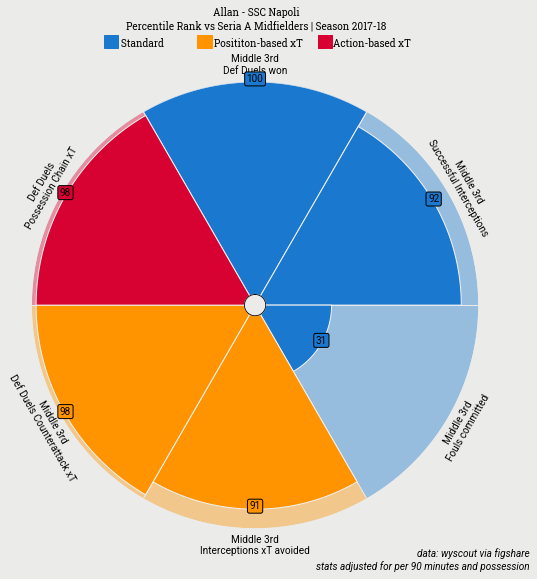

In [179]:
names = [
    "Middle 3rd\nDef Duels won", "Middle 3rd\nSuccessful Interceptions", "Middle 3rd\nFouls committed",
    "Middle 3rd\nInterceptions xT avoided", "Middle 3rd\nDef Duels Counterattack xT", "Def Duels\nPossession Chain xT"
]
    
baker = PyPizza(
    params=names,                   # list of parameters
    background_color="#EBEBE9",     # background color
    straight_line_color="#EBEBE9",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=0,               # linewidth of last circle
    other_circle_lw=0,              # linewidth for other circles
    # inner_circle_size=20          # size of inner circle
)

slice_colors = ["#1A78CF"] * 3 + ["#FF9300"] * 2 + ["#D70232"] * 1  
text_colors = ["black"]*6

font_normal = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto%5Bwdth,wght%5D.ttf?raw=true"))
font_italic = FontManager(("https://github.com/google/fonts/blob/main/apache/roboto/" "Roboto-Italic%5Bwdth,wght%5D.ttf?raw=true"))
font_bold = FontManager(("https://github.com/google/fonts/blob/main/apache/robotoslab/" "RobotoSlab%5Bwght%5D.ttf?raw=true"))

# plot pizza
fig, ax = baker.make_pizza(
    percentiles,                     # list of values
    figsize=(8,8.5),                 # adjust figsize according to your need
    color_blank_space="same",        # use same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.4,                 # alpha for blank-space colors
    kwargs_slices=dict(
        edgecolor="#F2F2F2", zorder=2, linewidth=1
    ),                               # values to be used when plotting slices
    kwargs_params=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, va="center"
    ),                               # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=11,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    )                                # values to be used when adding parameter-values
)

# add title
fig.text(
    0.515, 0.975, "Allan - SSC Napoli", size=16,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.953,
    "Percentile Rank vs Seria A Midfielders | Season 2017-18",
    size=13,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add credits
CREDIT_1 = "data: wyscout via figshare"
CREDIT_2 = "stats adjusted for per 90 minutes and possession"

fig.text(
    0.99, 0.07, f"{CREDIT_1}\n{CREDIT_2}", size=9,
    fontproperties=font_italic.prop, color="#000000",
    ha="right"
)

# add text
fig.text(
    0.28, 0.925, "Standard                    Posititon-based xT            Action-based xT", size=14,
    fontproperties=font_bold.prop, color="#000000"
)

# add rectangles
fig.patches.extend([
    plt.Rectangle(
        (0.25, 0.9225), 0.025, 0.021, fill=True, color="#1a78cf",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.412, 0.9225), 0.025, 0.021, fill=True, color="#ff9300",
        transform=fig.transFigure, figure=fig
    ),
    plt.Rectangle(
        (0.621, 0.9225), 0.025, 0.021, fill=True, color="#d70232",
        transform=fig.transFigure, figure=fig
    ),
])

plt.show()